# How air tight is your house?

This jupyter notebook supports the blog post [How air tight is your house?](https://medium.com/@drbenvincent/how-air-tight-is-your-house-7543ed7fe8dd) published on Medium.

Because we are only looking at CO₂ decay in unoccupied rooms overnight, we can simplify the equation decribing CO₂ concentration over time to just focus on the decreasing component:

$$
\frac{dc}{dt} = - ACPH \cdot (c - c_\text{env})
$$

where:
* $c$ is the CO₂ concentration in units of ppm
* $\frac{dc}{dt}$ is the rate of change of CO₂ concentration over time
* $ACPH$ is the air changes per hour
* $c_\text{env}$ is the external CO₂ concentration.

Solving this to describe the change in $c$ over time gives:

$$
c(t) = c_\text{env} + (c(0) - c_\text{env}) \cdot e^{-ACPH \cdot t}
$$

where $c(t)$ is the CO₂ concentration at time $t$, so $c(0)$ is the CO₂ concentration at the start of the measurement period, $c_\text{env}$ is the external CO₂ concentration, and $t$ is the time since the start of the measurement period, and $ACPH$ is the air changes per hour.

In [1]:
import pandas as pd
import pymc as pm
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sns.color_palette("tab10")
%config InlineBackend.figure_format = 'retina'
plt.rcParams["figure.figsize"] = [10, 4]

In [3]:
# CO₂ concentration of the external environment
CO2_ENV = 421.86

## Import and process the data

In [4]:
FILENAME = "data/Aranet4 25875_2024-01-22T18_43_30+0000.csv"

data = (
    pd.read_csv(FILENAME, parse_dates=["Time(dd/mm/yyyy)"], dayfirst=True)
    .rename({"Time(dd/mm/yyyy)": "date", "Carbon dioxide(ppm)": "CO2"}, axis=1)
    .set_index("date")
    .query("date > '2024-01-14 20:30'")
)
# convert to floats
data["CO2"] = data["CO2"].astype(float)
data.head()

,CO2,Temperature(°C),Relative humidity(%),Atmospheric pressure(hPa)
date,,,,
2024-01-14 20:30:13,1606.0,20.9,48,1006.4
2024-01-14 20:35:13,1554.0,20.7,48,1006.5
2024-01-14 20:40:13,1524.0,20.5,48,1006.6
2024-01-14 20:45:13,1539.0,20.4,48,1006.5
2024-01-14 20:50:13,1476.0,20.3,49,1006.5


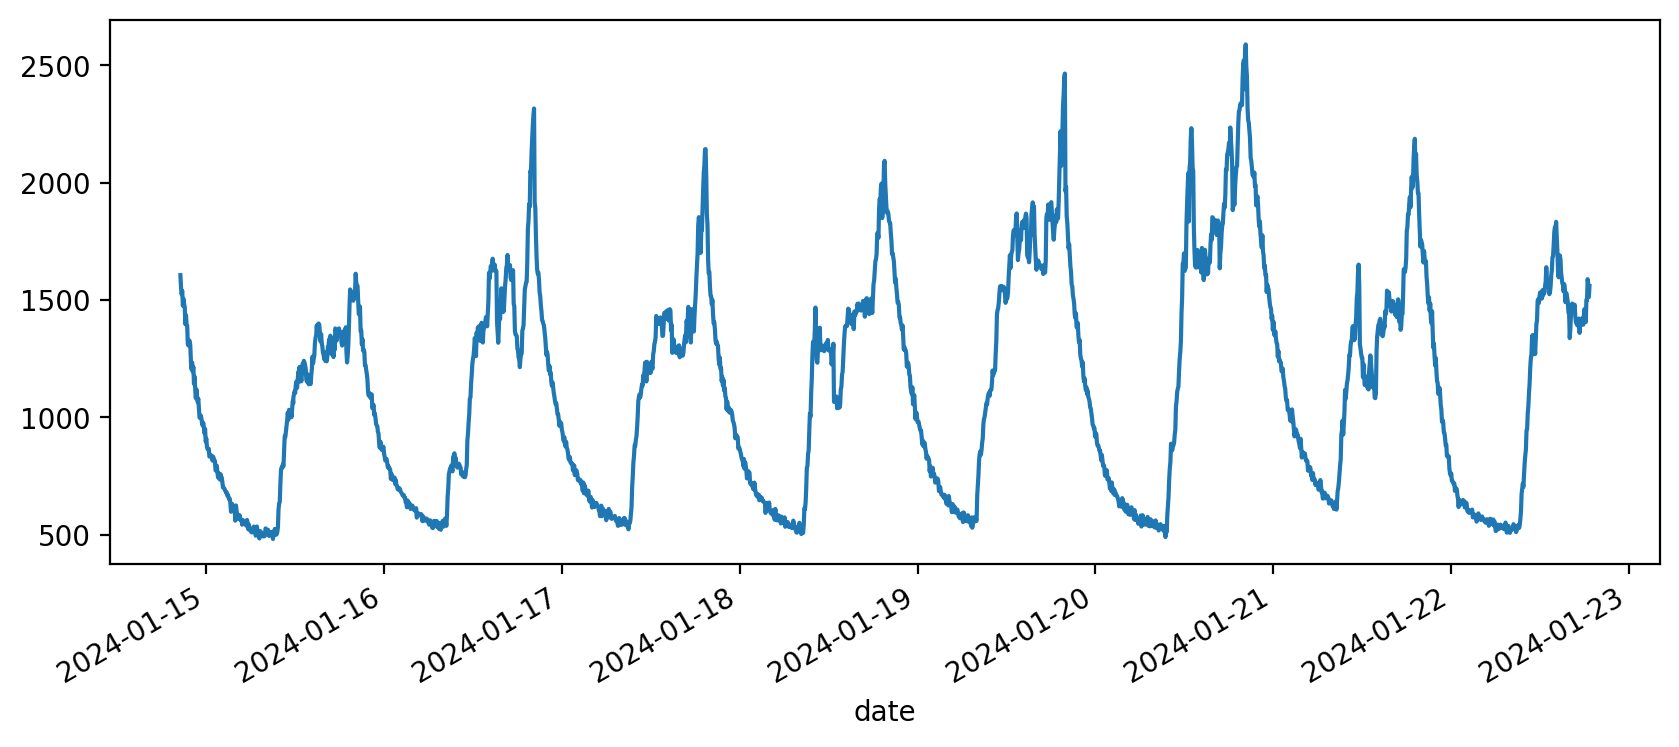

In [5]:
data["CO2"].plot();

In [6]:
def extract_period(df, start_time, end_time):
    period = df.copy()
    # filter for a specific time range
    period = period[(period.index >= start_time) & (period.index <= end_time)]
    # calculate time in hours
    period["time"] = (period.index - period.index[0]).total_seconds() / 3600
    # drop the date as index
    period.reset_index(inplace=True)
    # calculate time elapsed in hours
    period["time (hours)"] = (
        period["date"] - period["date"].iloc[0]
    ).dt.total_seconds() / 3600
    return period

First we need to extract out specific time ranges. Each range will have a label 0, 1, 2 ... etc. We will then use this label to index into a vector of parameters.


In [7]:
# lounge and kitchen space, overnight
times = (
    ("2024-01-14 20:30", "2024-01-15 09:30"),
    ("2024-01-15 20:00", "2024-01-16 08:00"),
    ("2024-01-16 20:15", "2024-01-17 08:50"),
    ("2024-01-17 19:40", "2024-01-18 08:15"),
    ("2024-01-18 20:00", "2024-01-19 07:30"),
    ("2024-01-19 20:00", "2024-01-20 09:20"),
    ("2024-01-20 20:30", "2024-01-21 08:20"),
    ("2024-01-21 20:20", "2024-01-22 08:30"),
)

n_days = len(times)

df = pd.DataFrame()
for i, range in enumerate(times):
    time_chunk = extract_period(data, pd.Timestamp(range[0]), pd.Timestamp(range[1]))
    time_chunk["i"] = i
    df = pd.concat([df, time_chunk])

df.reset_index(inplace=True)
df

,index,date,CO2,Temperature(°C),Relative humidity(%),Atmospheric pressure(hPa),time,time (hours),i
0,0,2024-01-14 20:30:13,1606.0,20.9,48,1006.4,0.000000,0.000000,0
1,1,2024-01-14 20:35:13,1554.0,20.7,48,1006.5,0.083333,0.083333,0
2,2,2024-01-14 20:40:13,1524.0,20.5,48,1006.6,0.166667,0.166667,0
3,3,2024-01-14 20:45:13,1539.0,20.4,48,1006.5,0.250000,0.250000,0
4,4,2024-01-14 20:50:13,1476.0,20.3,49,1006.5,0.333333,0.333333,0
...,...,...,...,...,...,...,...,...,...
1183,141,2024-01-22 08:06:47,524.0,18.3,53,979.6,11.746667,11.746667,7
1184,142,2024-01-22 08:11:47,521.0,18.3,53,979.9,11.830000,11.830000,7
1185,143,2024-01-22 08:16:47,528.0,18.3,52,980.1,11.913333,11.913333,7
1186,144,2024-01-22 08:21:47,531.0,18.4,52,980.2,11.996667,11.996667,7


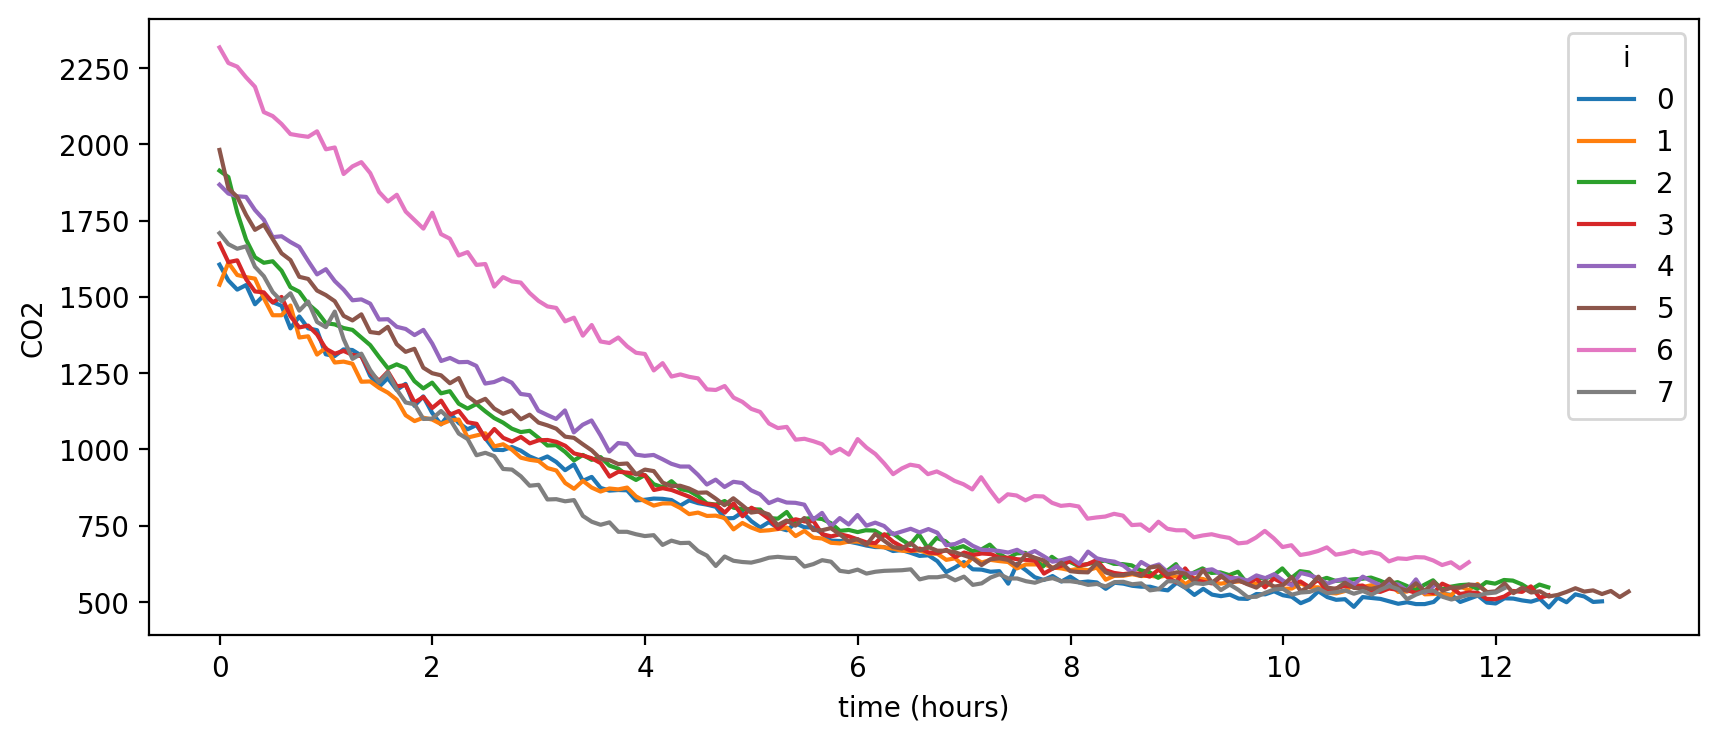

In [8]:
sns.lineplot(data=df, x="time (hours)", y="CO2", hue="i", palette="tab10");

In [9]:
df_initial = df.groupby("i")["CO2"].first()
df_initial

i
0    1606.0
1    1540.0
2    1914.0
3    1675.0
4    1868.0
5    1982.0
6    2318.0
7    1709.0
Name: CO2, dtype: float64

## Build a Bayesian model in PyMC

Now we'll build an unpooled Bayesian model.

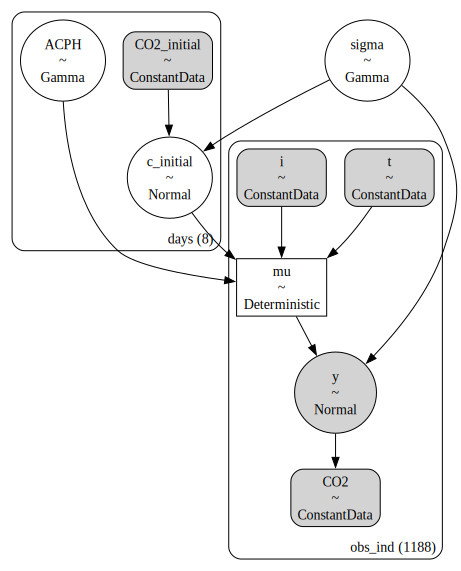

In [10]:
coords = {"days": np.arange(n_days), "obs_indx": df.index.values}

with pm.Model(coords=coords) as unpooled_model:
    # data
    CO2_initial = pm.ConstantData("CO2_initial", df_initial.values, dims="days")
    CO2 = pm.ConstantData("CO2", df["CO2"], dims="obs_ind")
    t = pm.ConstantData("t", df["time (hours)"].values, dims="obs_ind")
    i = pm.ConstantData("i", df["i"].values, dims="obs_ind")
    # priors
    sigma = pm.Gamma("sigma", 1, 1)
    c_initial = pm.Normal("c_initial", mu=CO2_initial, sigma=sigma, dims="days")
    ACPH = pm.Gamma("ACPH", mu=5, sigma=10, dims="days")
    # model
    mu = pm.Deterministic(
        "mu", CO2_ENV + (c_initial[i] - CO2_ENV) * pm.math.exp(-ACPH[i] * t),
        dims="obs_ind",
    )
    # likelihood
    pm.Normal("y", mu=mu, sigma=sigma, observed=CO2, dims="obs_ind")
    
pm.model_to_graphviz(unpooled_model)

In [11]:
with unpooled_model:
    idata = pm.sample()
    idata.extend(pm.sample_posterior_predictive(idata))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, c_initial, ACPH]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.
Sampling: [y]


If we wanted to do some checks to ensure the MCMC sampling worked well, we could examine the trace plots for each parameter. I did do this during this work and everything is fine, so I'll ommit the plots here. But if you want to see them, you could use the following code:
    
```python
az.plot_trace(idata, var_names=["~mu"])
plt.tight_layout()
```

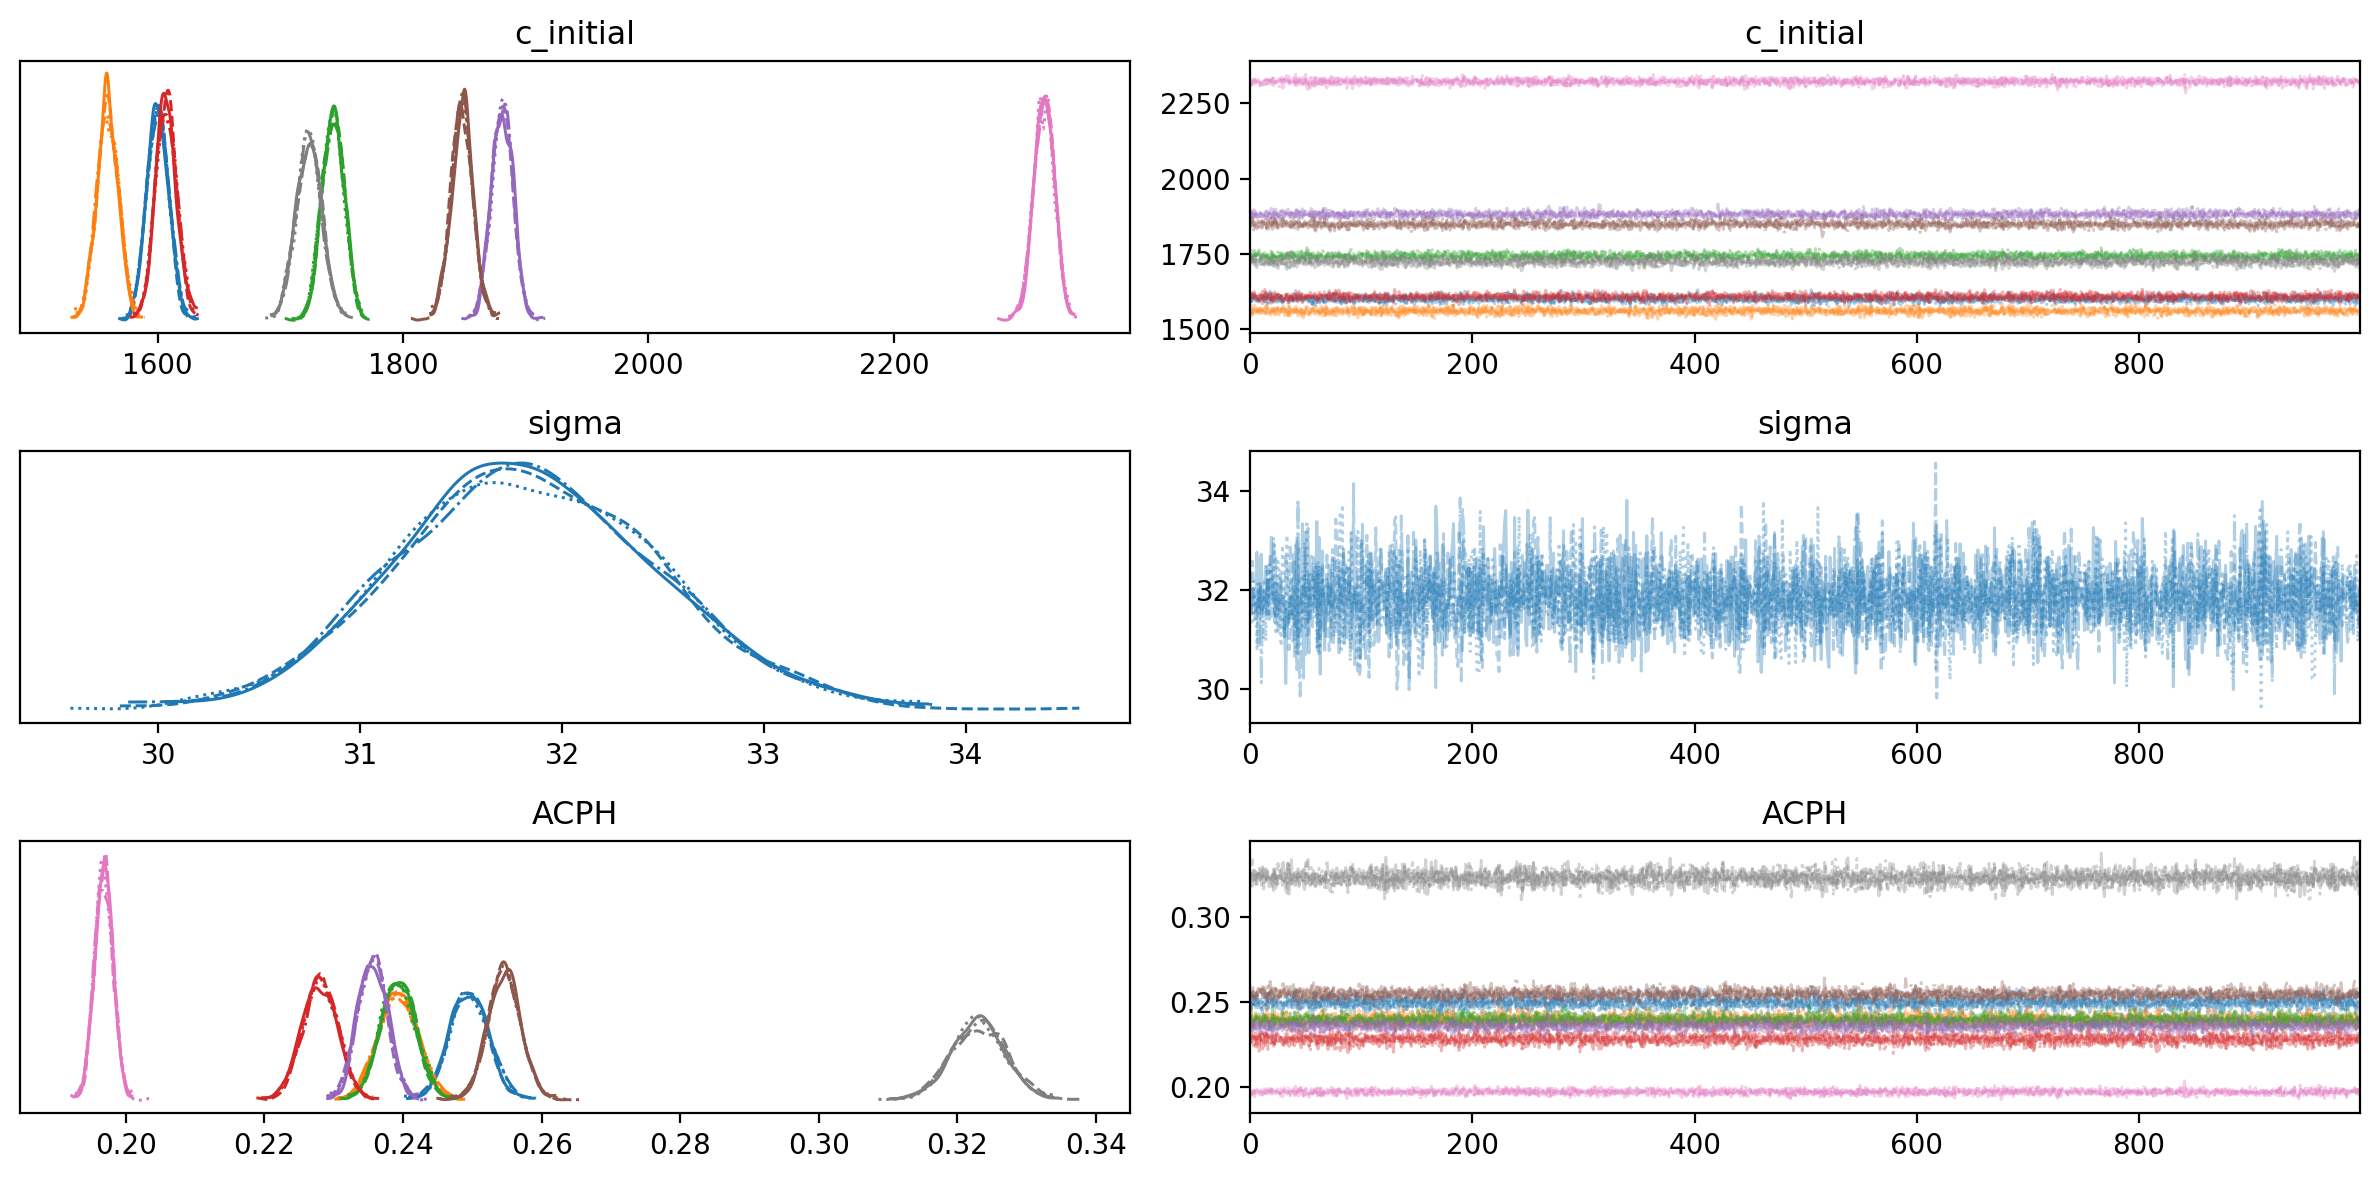

In [12]:
az.plot_trace(idata, var_names=["~mu"])
plt.tight_layout()

Now let's look at whether the model, and inferred parameters, can explain the data. If not, then the inferred ACPH values would not mean much.

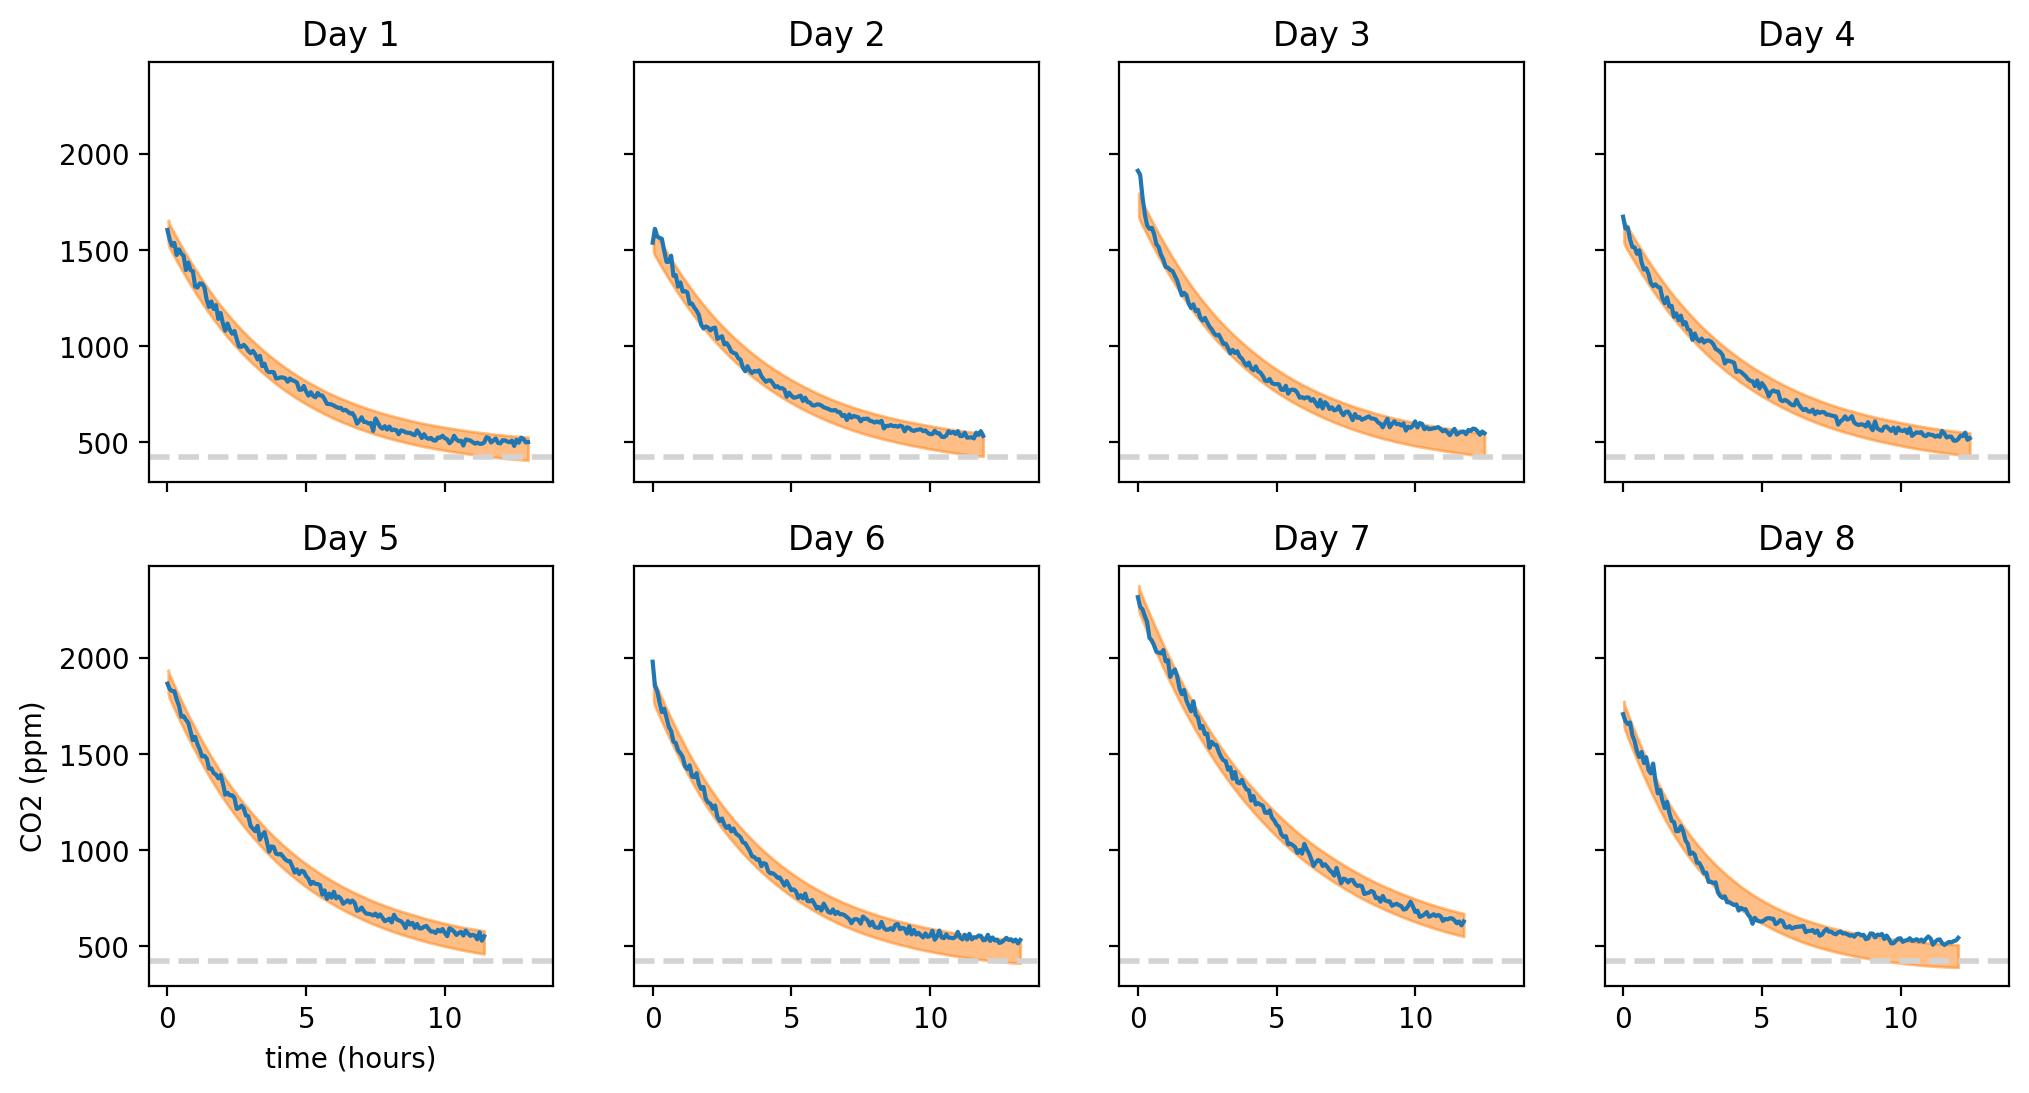

In [13]:
fig, axs = plt.subplots(2, n_days//2, sharex=True, sharey=True, figsize=(12, 6))

for i, ax in enumerate(axs.reshape(-1)):

    obs_list = df.query(f"i == {i}").index.values

    az.plot_hdi(
        df.query(f"i == {i}")["time (hours)"],
        idata.posterior_predictive["y"].sel(obs_ind=obs_list),
        ax=ax,
        fill_kwargs={"label": "Posterior predictive (94% HDI)"},
    )

    # plot data
    ax.plot(df.query(f"i == {i}")["time (hours)"], 
            df.query(f"i == {i}")["CO2"], label="observations")
    ax.set(title=f"Day {i+1}")
    
    ax.axhline(
        y=CO2_ENV,
        linewidth=2,
        c="lightgrey",
        ls="--",
        label=r"Environment CO$_2$",
    )

axs[1, 0].set(xlabel="time (hours)", ylabel="CO2 (ppm)");

## Results

Now we've done a reasonable amount of due diligence, we can focus on our main question: what is the ACPH for the ground floor of our house? 

The plot below shows the the posterior distribution of ACPH for the ground floor of our house. Each individual distribution corresponds to a different overnight period.

[Text(0.5, 0, 'Air Changes per Hour (ACPH)'),
 Text(0, 0.5, 'Posterior probability density'),
 [],
 Text(0.5, 1.0, 'Estimated Air Changes per Hour (ACPH) over 8 days')]

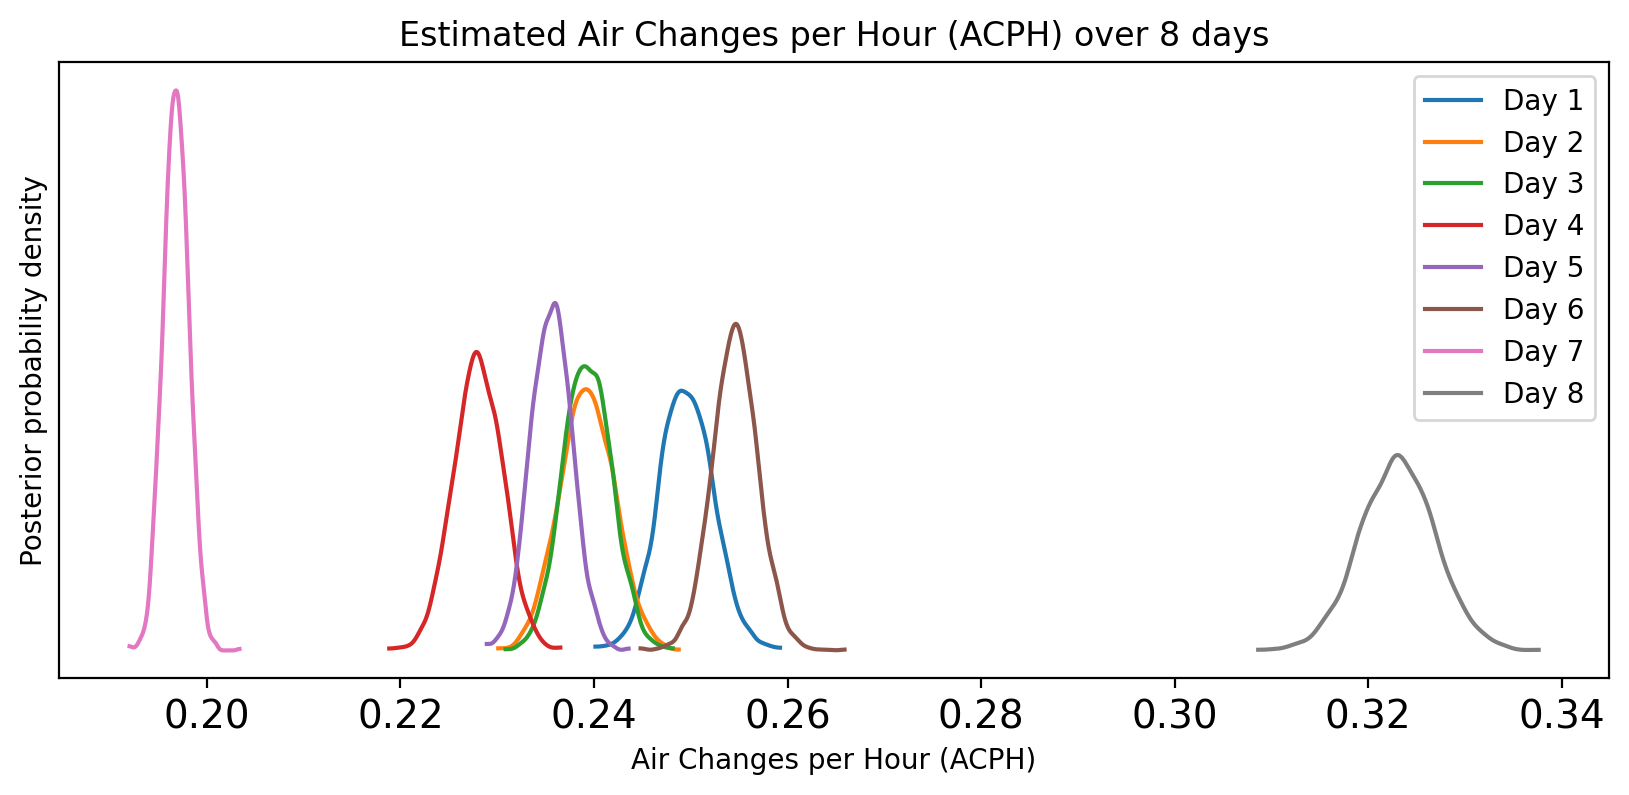

In [14]:
fig, ax = plt.subplots()
for i in np.arange(n_days):
    az.plot_dist(
        idata.posterior.ACPH.sel(days=i),
        color=f"C{i}",
        label=f"Day {i+1}",
    )

ax.set(
    xlabel="Air Changes per Hour (ACPH)",
    ylabel="Posterior probability density",
    yticks=[],
    title=f"Estimated Air Changes per Hour (ACPH) over {n_days} days",
)


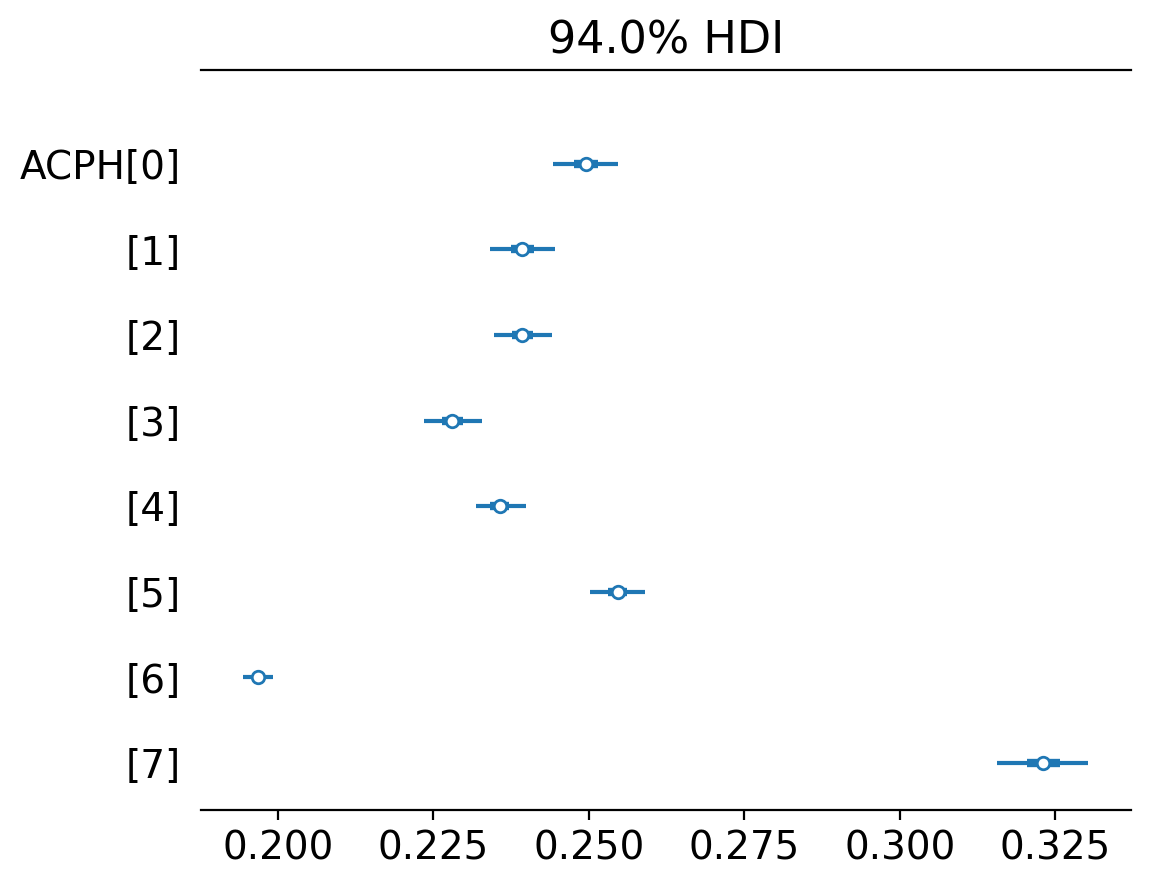

In [15]:
az.plot_forest(idata.posterior, var_names=["ACPH"], combined=True);